In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import shelve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import h5py
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Loading data into python
path = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_x.h5"
h5_img = h5py.File(path, "r")
ds_img = h5_img['x']
image = ds_img[0]

path2 = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_y.h5"
h5_lbl = h5py.File(path2, "r")
ds_lbl = h5_lbl['y']

For RGB images:

shape (3 x H x W)

H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [4]:
class pcamDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    self.length = len(labels)
  def __len__(self):
    return self.length
  def __getitem__(self, idx):
    np_array = np.array(self.images[idx])
    image_tensor = torch.from_numpy(np_array)
    image_perm = image_tensor.permute(2, 0, 1) # swap from (H, W, C) to (C, H, W)
    image_pad = F.pad(image_perm, (64, 64, 64, 64), 'constant') # pad 64 on all sides, 96x96 -> 224x224
    image_pad = image_pad.float() # change to float

    preprocess = transforms.Compose([ # Compose used for future edits
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize for resnet
    ])

    preprocess(image_pad)

    label = self.labels[idx]
    label_tensor = torch.tensor(label)

    sample = {'image': image_pad, 'label': label_tensor.long()}
    return sample

In [5]:
dset = pcamDataset(ds_img, ds_lbl)

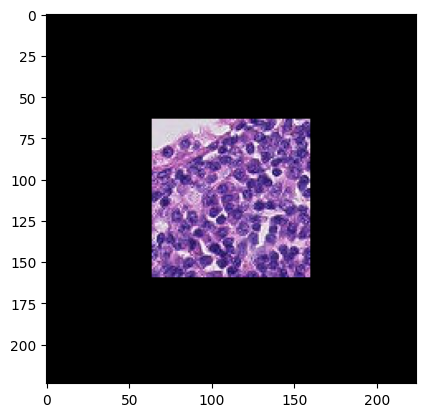

In [6]:
plt.imshow(dset.__getitem__(0)['image'].permute(1, 2, 0).numpy().astype('uint8'))

In [7]:
trainloader = DataLoader(dset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('done')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.6MB/s]


done


In [9]:
import gc
torch.cuda.empty_cache()
gc.collect()

57

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_mem = []
model.train()
for i, data in enumerate(trainloader): # 29 min train for rn18, 49min for rn50
    image = data['image'].to(device)
    label = data['label'].view(-1).to(device)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    loss_mem.append(loss.data.item())
    del output
    torch.cuda.empty_cache()

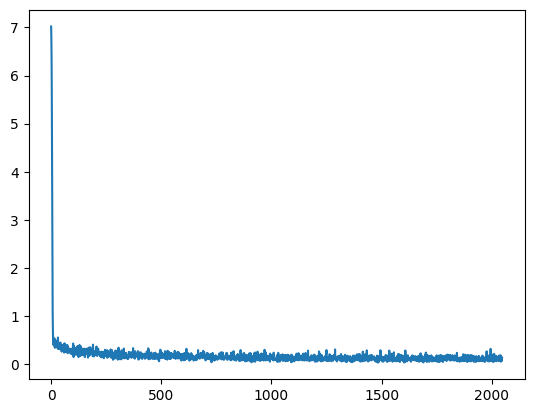

In [12]:
plt.plot(loss_mem)

In [ ]:
epoch =  # Change each training instance!
path = F"/content/gdrive/My Drive/checkpoints/%03d_resnet50.ckpt" % epoch
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
model_opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

checkpoint = torch.load("/content/gdrive/MyDrive/checkpoints/002_resnet50.ckpt") # Change me!
model.load_state_dict(checkpoint['model_state_dict'])
model_opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [ ]:
path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_x.h5"
h5_img_test = h5py.File(path, "r")
ds_img_test = h5_img_test['x']

path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_y.h5"
h5_lbl_test = h5py.File(path, "r")
ds_lbl_test = h5_lbl_test['y']

test_dset = pcamDataset(ds_img_test, ds_lbl_test)
test_trainloader = DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
score = []
for i, data in enumerate(test_trainloader):
  image = data['image'].to(device)
  label = data['label'].view(-1).to(device)
  output = model(image)
  output_numpy = output.cpu().data.numpy()
  output_argmax = np.argmax(output_numpy, axis=1)
  labels_numpy = label.cpu().data.numpy()
  score = np.concatenate((score, (labels_numpy==output_argmax).astype(int)), axis=0)

meanAccuracy = sum(score)/len(score)
print(meanAccuracy)

0.814544677734375
